<a href="https://colab.research.google.com/github/kittyschulz/visual_census/blob/master/car_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gdown

from __future__ import absolute_import, division, print_function, unicode_literals

# Import system helpers
import os
import pathlib
from os import listdir
from os.path import isfile, join

# Import TensorFlow and tf.keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import layers, models

!pip install -q -U tensorflow_hub
import tensorflow_hub as hub

# Import helper libraries
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pylab as plt

TensorFlow 2.x selected.


In [0]:
url = 'https://drive.google.com/uc?id=1VE6nVt99K6GRLxuVTKndDxV1o2-8Cihd'
output = 'images.tfrecords'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1VE6nVt99K6GRLxuVTKndDxV1o2-8Cihd
To: /content/images.tfrecords
997MB [00:19, 51.0MB/s]


'images.tfrecords'

In [0]:
url = 'https://drive.google.com/uc?id=1ajTURUIN7EHIP1mvJVLuo-uQDakFVbIJ'
output = 'cars_meta.mat'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ajTURUIN7EHIP1mvJVLuo-uQDakFVbIJ
To: /content/cars_meta.mat
100%|██████████| 3.18k/3.18k [00:00<00:00, 3.35MB/s]


'cars_meta.mat'

In [0]:
def read_label_names():
    cars_meta = scipy.io.loadmat('cars_meta.mat')['class_names']
    car_makes = []
    for vehicle in cars_meta[0]:
        car_makes.append([vehicle[0],vehicle[0].split(' ')[0], vehicle[0].split(' ')[-1]])
    car_makes = pd.DataFrame(car_makes, columns=['full_label', 'mnfr', 'year'])
    return {
        'mnfr_label': list(set(car_makes['mnfr'])),
        'year_label': list(set(car_makes['year'])),
        'full_label': list(set(car_makes['full_label'])),
    }

label_names_dict = read_label_names()
label_names_dict['value_label'] = ['Economy', 'Exotic', 'Luxury', 'Standard']
label_names_dict['type_label'] = ['convertible', 'coupe', 'hatchback', 'minivan', 'sedan', 'suv', 'truck', 'van', 'wagon']

In [0]:
#label_names_dict

In [0]:
label_type = 'type_label' # 'year_label' 'full_label'
label_names = label_names_dict[label_type]
num_categories = len(label_names)
IMG_SIZE = 224 # All images will be resized to 224 X 224

label_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(label_names),
        values=tf.range(num_categories),
    ),
    default_value=tf.constant(-1)
)

def _parse_example(example_proto):
  # Create a dictionary describing the features.
  image_feature_description = {
      'image_raw': tf.io.FixedLenFeature([], tf.string),
      'mnfr_label': tf.io.FixedLenFeature([], tf.string),
      'year_label': tf.io.FixedLenFeature([], tf.string),
      'full_label': tf.io.FixedLenFeature([], tf.string),
      'value_label': tf.io.FixedLenFeature([], tf.string),
      'type_label': tf.io.FixedLenFeature([], tf.string),
      'bbox': tf.io.FixedLenFeature([4,], tf.float32),
  }
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def _preprocess(ds):
  image = tf.image.decode_jpeg(ds['image_raw'], channels=3)
  HWC = tf.shape(image)
  bbox = ds['bbox'] / [HWC[0], HWC[1], HWC[0], HWC[1]]
  cropped = tf.image.crop_and_resize([image], [bbox], [0], [IMG_SIZE, IMG_SIZE])
  label = label_table.lookup(ds[label_type])
  image = tf.squeeze(cropped) / 255.0 # Scale images pixel values to [0, 1.0]
  return image, label

#  Create tf data dataset
dataset = tf.data.TFRecordDataset('images.tfrecords')
dataset = dataset.map(_parse_example)
dataset = dataset.map(_preprocess)
# train_dataset has 1st 6400 images and rest goes to val dataset
train = dataset.take(6400)
validation = dataset.skip(6400)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

In [0]:
def visualize_batch(image_batch, label_batch, title=""):
  batch_size = image_batch.shape[0]
  images_per_row = 8
  num_rows = batch_size // images_per_row
  plt.figure(figsize=(2 * images_per_row, 2 * num_rows))
  plt.subplots_adjust(hspace=0.5)
  for n in range(batch_size):
    plt.subplot(num_rows, images_per_row, n+1)
    plt.imshow(image_batch[n])
    plt.title(label_names[label_batch[n]])
    plt.axis('off')
  _ = plt.suptitle(title)

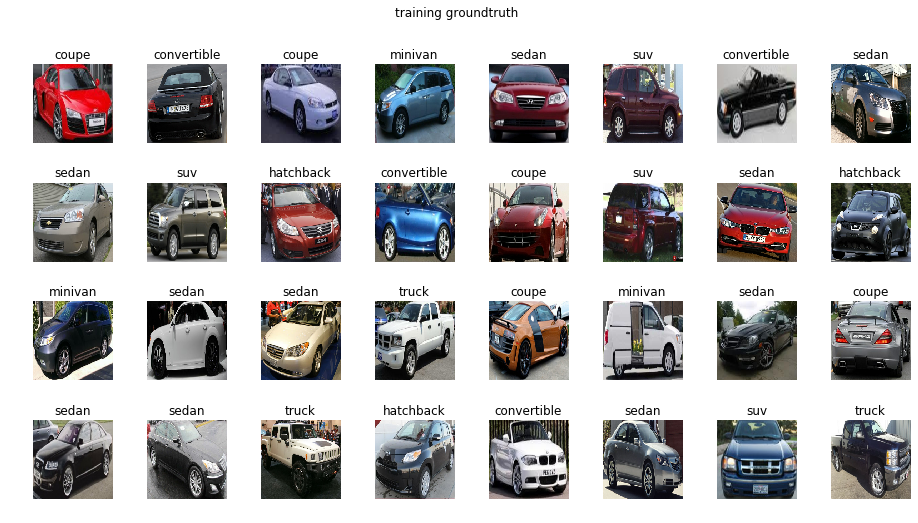

In [0]:
for image_batch, label_batch in train_batches.take(1):
  pass

visualize_batch(image_batch, label_batch, "training groundtruth")

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,3),
                                         trainable=True)

In [0]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(num_categories, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 2,235,401
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
history = model.fit(train_batches,
                    epochs=5,
                    validation_data=validation_batches)

Epoch 1/5
      1/Unknown - 6s 6s/step

KeyboardInterrupt: ignored

In [0]:
predicted_labels_batch = np.argmax(model(image_batch).numpy(), axis=-1)
visualize_batch(image_batch, predicted_labels_batch, "Predictions")